In [1]:
#%pip install tensorflow

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [14]:
PATH="C://Users//Harshita//Downloads//archive (6)"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

In [15]:
# Create tf.data.Dataset for training, validation and test using Keras image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.


In [16]:
# Control bathches sizes

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 1231
Number of validation batches: 43
Number of test batches: 43


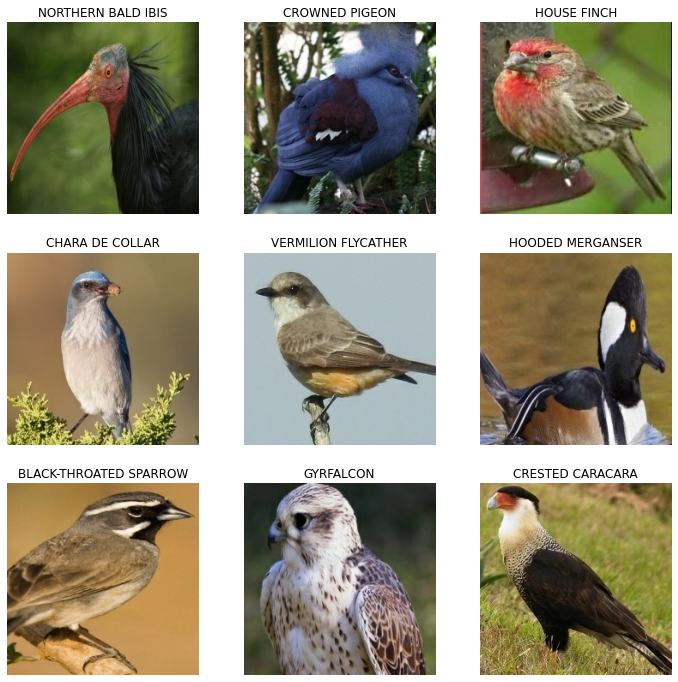

In [17]:
# The first nine images and labels from training set

class_names = train_dataset.class_names

plt.figure(figsize=(12,12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
# for better data performance using buffered prefetching 

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Simple Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

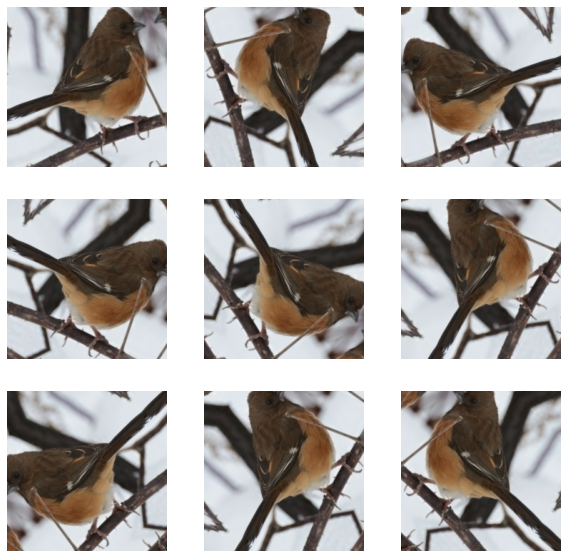

In [20]:
# Result for an image after apply the augmentation

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Create a base pre-trained model**

In [21]:
# Download mobilenet_v2 model architecture.

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [22]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [23]:
# This feature extractor converts each 224x224x3 image into a 7x7x1280 block of features

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [24]:
# Freeze the model weights before compile and train the model.

base_model.trainable = False

In [25]:
# Convert the features to a single 1280 element vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
# Apply a tf.keras.layers.Dense layer to convert these features into 270 predictions per image

prediction_layer = tf.keras.layers.Dense(280, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 280)


In [27]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
# Compile the model before training it. Since there are multi classes, I will use a Sparse Categorical Crossentropy loss 

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

C:\Users\Harshita\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

**Train The Model**

In [32]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1231/1231 [==============================] - 1576s 1s/step - loss: 1.9133 - acc: 0.6615 - val_loss: 1.3631 - val_acc: 0.8240
Epoch 2/10
1231/1231 [==============================] - 1555s 1s/step - loss: 1.3986 - acc: 0.7370 - val_loss: 0.9758 - val_acc: 0.8647
Epoch 3/10
1231/1231 [==============================] - 1568s 1s/step - loss: 1.1225 - acc: 0.7782 - val_loss: 0.7667 - val_acc: 0.8865
Epoch 4/10
1231/1231 [==============================] - 1545s 1s/step - loss: 0.9578 - acc: 0.8030 - val_loss: 0.6356 - val_acc: 0.9040
Epoch 5/10
1231/1231 [==============================] - 1619s 1s/step - loss: 0.8447 - acc: 0.8211 - val_loss: 0.5486 - val_acc: 0.9142
Epoch 6/10
1231/1231 [==============================] - 1503s 1s/step - loss: 0.7761 - acc: 0.8312 - val_loss: 0.4829 - val_acc: 0.9229
Epoch 7/10
1231/1231 [==============================] - 1550s 1s/step - loss: 0.7086 - acc: 0.8433 - val_loss: 0.4342 - val_acc: 0.9258
Epoch 8/10
1231/1231 [==========================

**Learning Curves**

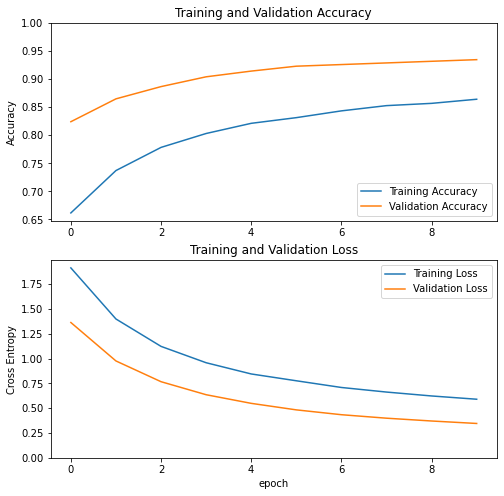

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# Finaly we can verify the performance of the model on test set.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

43/43 [==============================] - 40s 916ms/step - loss: 0.3128 - acc: 0.9440
Test accuracy : 0.9440000057220459


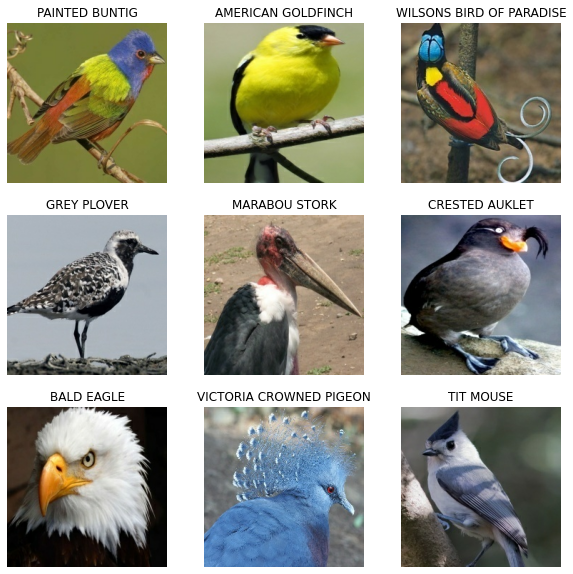

In [35]:
# Plot prediction results

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_id[i]])
    plt.axis("off")